In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
from skimage.morphology import erosion
from skimage.morphology import disk
from skimage.filters import prewitt
import math
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from skimage import color, io, measure, segmentation, img_as_ubyte
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.color import label2rgb
from scipy.spatial import distance
from skimage.transform import rotate
from skimage.transform import EuclideanTransform
from skimage.transform import warp
from skimage.transform import matrix_transform
from exam_functions import *

# DEC 2022


## 1


1. Reads the DICOM image
2. Uses the annotated regions to extract pixel values in the liver, kidney and aorta
   regions
3. Determines two threshold using minimum distance classification. Threshold
   number (t1) separates the liver and the kidney. The second threshold (t2)
   separates the kidney and the aorta.
4. Segments the DICOM image by setting all pixel that have a value >t1 and <t2 to
   foreground and the rest to background.
5. Computes the DICE score between the resulting segmented image and the
   KidneyROI.png image.


In [3]:
in_dir = "Exams/dec2022/data/dicom/"
im_name = "1-162.dcm"
ct = dicom.read_file(in_dir + im_name)
img = ct.pixel_array

In [4]:
liver_roi = io.imread(in_dir + "LiverROI.png")
liver_mask = liver_roi > 0
liver_values = img[liver_mask]
kidney_roi = io.imread(in_dir + "KidneyROI.png")
kidney_mask = kidney_roi > 0
kidney_values = img[kidney_mask]
aorta_roi = io.imread(in_dir + "AortaROI.png")
aorta_mask = aorta_roi > 0
aorta_values = img[aorta_mask]
# print(f"liver: {liver_values}\nkidney: {kidney_values}\naorta: {aorta_values}")

In [5]:
mu_liver = np.mean(liver_values)
mu_kidney = np.mean(kidney_values)
mu_aorta = np.mean(aorta_values)

t_liver_kidney = (mu_liver + mu_kidney) / 2
t_kidney_aorta = (mu_kidney + mu_aorta) / 2
print(t_liver_kidney, t_kidney_aorta)

135.53619417264818 196.7035801627044


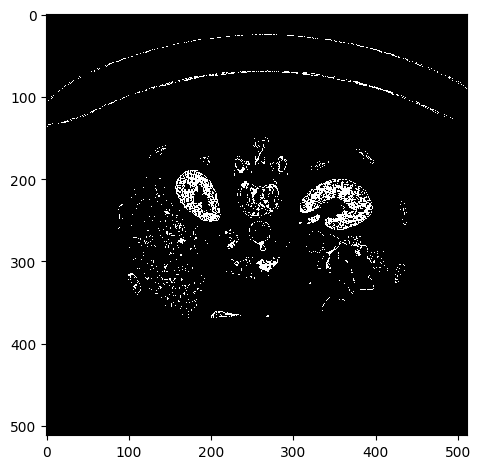

In [6]:
kidney_img = (img > t_liver_kidney) & (img < t_kidney_aorta)
io.imshow(kidney_img)
io.show()

In [9]:
dice_score = 1 - distance.dice(kidney_img.ravel(), kidney_roi.ravel())
print(f"DICE score {dice_score:.3f}")

DICE score 0.241


## 2


The five data points (x, y):

(7,13), (9,10), (6,10), (6,8), (3,6)

result in the corresponding five Hough space sinograms (curves in Hough space) shown below.

Two Hough space sinograms are crossing at (rho = 0.29, theta = 151 ).

What are the corresponding data points for the two crossing curves in Hough space? (approximately)


In [10]:
# Mapping
# Given xy-coordinates
x = 5
y = 8

# Convert x and y to Hough space parameters (rho and theta)
rho = np.sqrt(x * 2 + y * 2)  # Calculate rho using the distance formula
theta = np.arctan2(y, x)  # Calculate theta using the arctan2 function

# Convert theta from radians to degrees for display (optional)
theta_degrees = theta * (180 / np.pi)

# Display the Hough space parameters
print("Hough space parameters:")
print(f"Rho: {rho:.2f}")
print(f"Theta (degrees): {theta_degrees:.2f}")


# Mapping from Hough Space to Cartesian Space
# Given Hough space parameters
rho = 0.29
theta_degrees = 151

# Convert theta from degrees to radians
theta_rad = theta_degrees * (np.pi / 180)


# Function to calculate y for a given x
def calculate_y(x):
    return (rho - x * np.cos(theta_rad)) / np.sin(theta_rad)


# Calculate y for a range of x values
x_values = [7, 9, 6, 6, 3]  # Choose different x values
corresponding_y_values = [calculate_y(x) for x in x_values]

# Display the approximate data points
print("Approximate data points in the xy-plane:")
for i, x in enumerate(x_values):
    y = corresponding_y_values[i]
    print(f"({x}, {y:.2f})")

Hough space parameters:
Rho: 5.10
Theta (degrees): 57.99
Approximate data points in the xy-plane:
(7, 13.23)
(9, 16.83)
(6, 11.42)
(6, 11.42)
(3, 6.01)


In [14]:
xs = [7, 9, 6, 6, 3]
ys = [13, 10, 10, 8, 6]

theta = 151
rho = 0.29

for x in xs:
    y = -x * (
        math.cos(math.radians(theta)) / math.sin(math.radians(theta))
    ) + rho * 1 / math.sin(math.radians(theta))
    print(f"Found pairs (x,y) = ({x}, {y:.0f})")

Found pairs (x,y) = (7, 13)
Found pairs (x,y) = (9, 17)
Found pairs (x,y) = (6, 11)
Found pairs (x,y) = (6, 11)
Found pairs (x,y) = (3, 6)
